In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# 1. Setup tools for cleaning text (Updated with the missing resource)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

# --- CHANGE THIS TO YOUR ACTUAL FOLDER PATH ---
folder_path = '/content/drive/MyDrive/dataset/'

def clean_text(text):
    """The 'Cleaning Machine': Turns messy text into AI-ready text."""
    text = str(text).lower()
    text = text.replace('$', ' dollar ').replace('€', ' euro ')
    text = re.sub(r'[^a-zA-Z0-9.% ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

# 2. LOAD DATASET 1: NER Data (train.txt)
try:
    with open(os.path.join(folder_path, 'train.txt'), 'r') as f:
        ner_lines = f.readlines()
    ner_text = " ".join([line.split()[0] for line in ner_lines if len(line.split()) > 0])
except FileNotFoundError:
    print("Error: train.txt not found. Check your folder_path.")
    ner_text = ""

# 3. LOAD DATASET 2: Financial Sentences (Sentences_AllAgree.txt)
try:
    with open(os.path.join(folder_path, 'Sentences_AllAgree.txt'), 'r', encoding='latin-1') as f:
        sentiment_sentences = f.readlines()
except FileNotFoundError:
    print("Error: Sentences_AllAgree.txt not found.")
    sentiment_sentences = []

# 4. LOAD DATASET 3: Tabular Data (demo_facts.csv)
try:
    facts_df = pd.read_csv(os.path.join(folder_path, 'demo_facts.csv'))
    facts_sentences = facts_df.iloc[:, 0].astype(str).tolist()
except FileNotFoundError:
    print("Error: demo_facts.csv not found.")
    facts_sentences = []

# 5. COMBINE AND CLEAN
master_list = [ner_text] + sentiment_sentences + facts_sentences
# Filter out empty strings if any files failed to load
master_list = [s for s in master_list if s.strip()]

cleaned_data = [clean_text(doc) for doc in master_list]

# 6. SAVE BACK TO DRIVE
final_report = pd.DataFrame({
    'Original_Data': master_list,
    'AI_Ready_Data': cleaned_data
})

output_path = os.path.join(folder_path, 'combined_financial_data.csv')
final_report.to_csv(output_path, index=False)

print(f"Success! Your combined file is saved at: {output_path}")
print(f"Total rows processed: {len(final_report)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Success! Your combined file is saved at: /content/drive/MyDrive/dataset/combined_financial_data.csv
Total rows processed: 2500


--- Dataset Overview ---
Total Rows: 2500
                                       Original_Data  \
0  -DOCSTART- EU rejects German call to boycott B...   
1  According to Gran , the company has no plans t...   
2  For the last quarter of 2010 , Componenta 's n...   
3  In the third quarter of 2010 , net sales incre...   
4  Operating profit rose to EUR 13.1 mn from EUR ...   

                                       AI_Ready_Data  
0  docstart eu reject german call to boycott brit...  
1  according to gran the company ha no plan to mo...  
2  for the last quarter of 2010 componenta s net ...  
3  in the third quarter of 2010 net sale increase...  
4  operating profit rose to eur 13.1 mn from eur ...  


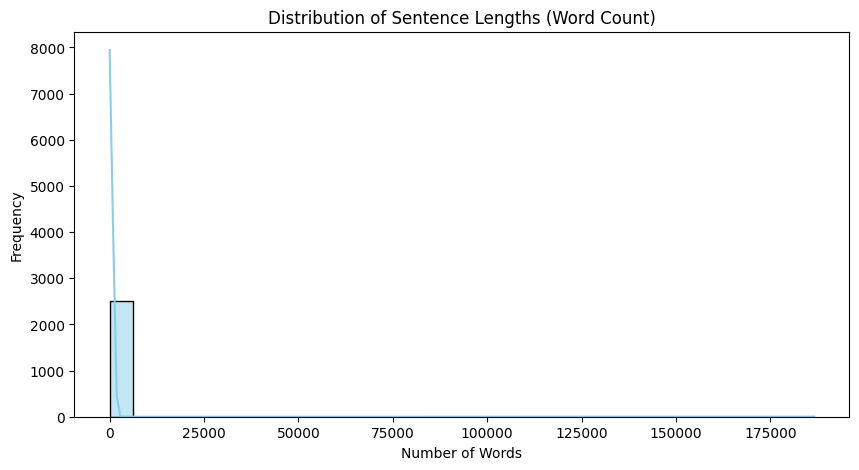

/tmp/ipython-input-3306316676.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=words_df, palette='viridis')


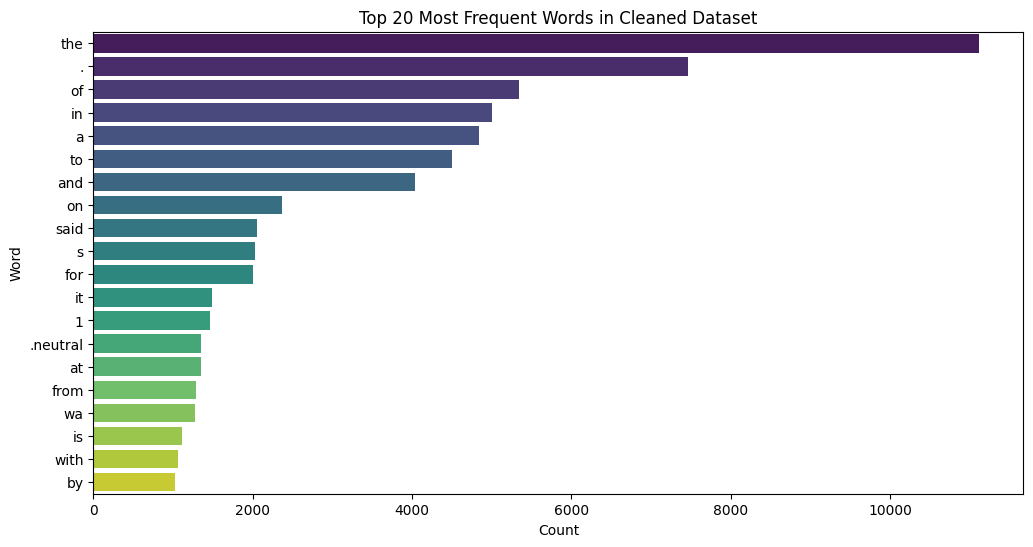

EDA Complete! Charts generated and eda_summary.txt saved to Drive.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# 1. Load your cleaned data
# Make sure this path matches where you saved the file in the previous step
file_path = '/content/drive/MyDrive/dataset/combined_financial_data.csv'
df = pd.read_csv(file_path)

print("--- Dataset Overview ---")
print(f"Total Rows: {len(df)}")
print(df.head())

# 2. Analyze Sentence Lengths
# We want to know how many words are in each sentence on average.
df['word_count'] = df['AI_Ready_Data'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentence Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# 3. Analyze Word Frequency (Most Common Financial Terms)
# This finds the top 20 most used words in your dataset.
all_words = " ".join(df['AI_Ready_Data'].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Convert to a DataFrame for easy plotting
words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=words_df, palette='viridis')
plt.title('Top 20 Most Frequent Words in Cleaned Dataset')
plt.show()

# 4. Save basic stats for your Mentor report
with open('/content/drive/MyDrive/dataset/eda_summary.txt', 'w') as f:
    f.write(f"Total rows: {len(df)}\n")
    f.write(f"Average word count: {df['word_count'].mean():.2f}\n")
    f.write(f"Top 5 words: {common_words[:5]}\n")

print("EDA Complete! Charts generated and eda_summary.txt saved to Drive.")

In [5]:
import pandas as pd
from collections import Counter
import ast

# 1. Load your combined data
file_path = '/content/drive/MyDrive/dataset/combined_financial_data.csv'
df = pd.read_csv(file_path)

# 2. Define the "Rules" (Valid Labels) from your mentor's file
valid_labels = {
    "O",
    "B-ORG", "I-ORG",
    "B-METRIC", "I-METRIC",
    "B-VALUE", "I-VALUE",
    "B-DATE", "I-DATE",
    "B-EVENT", "I-EVENT",
    "B-TICKER", "I-TICKER"
}

def validate_row(text):
    """
    Checks if a row of text can be properly tokenized for NER.
    Since we don't have human-labeled tags for everything yet,
    this checks if the text is clean enough to BE labeled.
    """
    if pd.isna(text) or text.strip() == "":
        return "Empty Text"

    # In a real labeled dataset, we would check if len(tokens) == len(labels)
    # For now, we check if the text is too short or has illegal characters
    if len(str(text).split()) < 3:
        return "Text too short (possible noise)"

    return "Valid"

# 3. Run Validation
print("--- Starting Data Validation ---")
df['validation_status'] = df['AI_Ready_Data'].apply(validate_row)

# 4. Show Results
error_counts = df['validation_status'].value_counts()
print("\nValidation Report:")
print(error_counts)

# 5. Filter out bad data
clean_df = df[df['validation_status'] == "Valid"].copy()
print(f"\nOriginal Row Count: {len(df)}")
print(f"Clean Row Count: {len(clean_df)}")

# Save the final validated version for training
clean_df.to_csv('/content/drive/MyDrive/dataset/validated_financial_data.csv', index=False)
print("\nSuccess! Validated data saved to 'validated_financial_data.csv'.")

--- Starting Data Validation ---

Validation Report:
validation_status
Valid                              2264
Text too short (possible noise)     236
Name: count, dtype: int64

Original Row Count: 2500
Clean Row Count: 2264

Success! Validated data saved to 'validated_financial_data.csv'.


In [6]:
!pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=a5e7d70f108489ebbcb160d65d236fb736eeb4b10d278ca57a6eca7ad24c668a
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [7]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorForTokenClassification

# 1. SETUP PATHS
# Make sure this points to where your train.txt is
folder_path = '/content/drive/MyDrive/dataset/'
train_path = folder_path + 'train.txt'

# 2. FUNCTION TO READ THE DATA (WORDS + LABELS)
def read_conll_file(file_path):
    sentences = []
    labels = []
    current_sent = []
    current_labels = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line: # Empty line means end of sentence
                if current_sent:
                    sentences.append(current_sent)
                    labels.append(current_labels)
                    current_sent = []
                    current_labels = []
            else:
                parts = line.split()
                if len(parts) >= 2: # Ensure we have Word + Label
                    current_sent.append(parts[0])
                    current_labels.append(parts[-1]) # The last part is the label

    return sentences, labels

print("Reading train.txt...")
train_tokens, train_labels = read_conll_file(train_path)
print(f"Success! Loaded {len(train_tokens)} sentences with labels.")

# 3. CREATE LABEL MAPS (The AI needs numbers, not text)
# We find all unique labels (B-ORG, I-ORG, etc.) and give them IDs
unique_labels = sorted(list(set(label for sent in train_labels for label in sent)))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for i, label in enumerate(unique_labels)}

print(f"Found {len(unique_labels)} unique labels: {unique_labels}")

# 4. PREPARE FOR HUGGING FACE
raw_dataset = Dataset.from_dict({
    "id": list(range(len(train_tokens))),
    "tokens": train_tokens,
    "ner_tags": [[label2id[l] for l in sent] for sent in train_labels]
})

# 5. LOAD FINBERT TOKENIZER
# We use 'yiyanghkust/finbert-tone' as a base, or standard bert if preferred.
# For this internship, a standard BERT or FinBERT base works.
model_checkpoint = "yiyanghkust/finbert-pretrain"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 6. THE MENTOR'S FIX (Logic from jj.txt)
# This aligns the labels when the tokenizer splits words
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100) # Special ID for ignored tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx]) # Start of a new word
            else:
                label_ids.append(-100) # Sub-word (e.g., '##ments') gets ignored
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 7. APPLY THE FIX
print("Aligning tokens and labels...")
tokenized_datasets = raw_dataset.map(tokenize_and_align_labels, batched=True)
print("Data Preparation Complete! Ready for Training.")

Reading train.txt...
Success! Loaded 14987 sentences with labels.
Found 9 unique labels: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Aligning tokens and labels...


Map:   0%|          | 0/14987 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Data Preparation Complete! Ready for Training.


In [9]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

# --- RE-DEFINE MODEL NAME (Just in case) ---
model_checkpoint = "yiyanghkust/finbert-pretrain"

# 1. SETUP THE MODEL
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

# 2. SETUP TRAINING SETTINGS (Fixed the Multiple Values Error)
args = TrainingArguments(
    output_dir="/content/drive/MyDrive/dataset/checkpoints", # This is now the ONLY output dir
    eval_strategy = "no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch"
)

# 3. BATCH THE DATA
data_collator = DataCollatorForTokenClassification(tokenizer)

# 4. INITIALIZE THE TRAINER
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# 5. START TRAINING
print("Starting Training... (This may take 10-15 minutes)")
trainer.train()

# 6. SAVE YOUR FINAL MODEL
save_path = "/content/drive/MyDrive/dataset/MyFinBERT_Model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"TRAINING COMPLETE! Your custom model is saved at: {save_path}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3698555308.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Training... (This may take 10-15 minutes)


Step,Training Loss
500,0.221700


Step,Training Loss
500,0.221700
1000,0.108500
1500,0.062000
2000,0.050100
2500,0.029400


TRAINING COMPLETE! Your custom model is saved at: /content/drive/MyDrive/dataset/MyFinBERT_Model


In [10]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import os

# 1. CREATE THE TEST FILE MANUALLY (To fix the "File Not Found" error)
test_sentences = [
    "Microsoft posted operating income of $83.4 billion for fiscal year 2023.",
    "Amazon reported a net profit of $10.6 billion in the second quarter of 2024.",
    "Tesla recorded vehicle deliveries of 443,956 units during Q1 2023.",
    "Reliance Industries announced a capital expenditure plan worth ₹75,000 crore for FY25.",
    "JPMorgan Chase generated revenue of $39.9 billion in Q4 2023.",
    "Meta Platforms saw advertising revenue rise to $31.5 billion in the first quarter of 2024.",
    "Infosys declared an earnings per share of ₹18.3 for the quarter ended March 2024.",
    "Alphabet reported free cash flow of $17.1 billion in Q3 2023.",
    "Tata Motors completed the acquisition of Iveco’s defense business in December 2023.",
    "Netflix added 8.8 million subscribers during the third quarter of 2023.",
    "Goldman Sachs reported return on equity of 7.5% for the full year 2023.",
    "Samsung Electronics posted semiconductor losses of ₩4.6 trillion in Q2 2023.",
    "Boeing recorded commercial airplane deliveries of 528 units in 2023.",
    "PayPal announced a share buyback program valued at $5 billion in January."
]

# 2. LOAD YOUR SAVED MODEL
# Note: Ensure this path is where you actually saved the model in the previous step
model_path = "/content/drive/MyDrive/dataset/MyFinBERT_Model"

try:
    print(f"Loading model from {model_path}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForTokenClassification.from_pretrained(model_path)
except OSError:
    print("\nCRITICAL ERROR: Model not found!")
    print(f"Please check if your model is actually saved at: {model_path}")
    print("If you saved it in 'FinanceProject' instead of 'dataset', change the path above.")
    raise

# 3. RUN PREDICTIONS
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

print("\n--- AI PREDICTION REPORT ---\n")

for i, sentence in enumerate(test_sentences):
    print(f"Sentence {i+1}: {sentence}")
    results = ner_pipeline(sentence)

    if len(results) > 0:
        print("  Found Entities:")
        for entity in results:
            score = f"{entity['score']:.2f}"
            print(f"    -> {entity['word']} ({entity['entity_group']}) [Conf: {score}]")
    else:
        print("  No entities found.")
    print("-" * 50)

Loading model from /content/drive/MyDrive/dataset/MyFinBERT_Model...


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



--- AI PREDICTION REPORT ---

Sentence 1: Microsoft posted operating income of $83.4 billion for fiscal year 2023.
  Found Entities:
    -> microsoft (ORG) [Conf: 1.00]
--------------------------------------------------
Sentence 2: Amazon reported a net profit of $10.6 billion in the second quarter of 2024.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Found Entities:
    -> amazon (ORG) [Conf: 1.00]
--------------------------------------------------
Sentence 3: Tesla recorded vehicle deliveries of 443,956 units during Q1 2023.
  Found Entities:
    -> tesla (ORG) [Conf: 0.98]
--------------------------------------------------
Sentence 4: Reliance Industries announced a capital expenditure plan worth ₹75,000 crore for FY25.
  Found Entities:
    -> reliance industries (ORG) [Conf: 1.00]
    -> ₹75 (MISC) [Conf: 0.86]
--------------------------------------------------
Sentence 5: JPMorgan Chase generated revenue of $39.9 billion in Q4 2023.
  Found Entities:
    -> jpmorgan chase (ORG) [Conf: 1.00]
--------------------------------------------------
Sentence 6: Meta Platforms saw advertising revenue rise to $31.5 billion in the first quarter of 2024.
  Found Entities:
    -> meta platforms (ORG) [Conf: 0.97]
--------------------------------------------------
Sentence 7: Infosys declared an earnings per share of ₹18.3 for the quarter 

In [11]:
import re

def extract_financial_data(sentence, ner_pipeline):
    # 1. AI LAYER: Find Company
    ai_results = ner_pipeline(sentence)
    company = "Unknown"
    for entity in ai_results:
        if entity['entity_group'] == 'ORG':
            company = entity['word']
            break

    # 2. LOGIC LAYER: Extended Rules for Milestone 3
    # Improved patterns to catch non-currency numbers and complex metrics

    # Metrics: Added 'subscribers', 'eps', 'return on equity', 'acquisition', 'buyback'
    metric_pattern = r'(?:operating income|net profit|revenue|sales|deliveries|expenditure|cash flow|losses|earnings per share|subscribers|return on equity|acquisition|share buyback)'

    # Values: Now catches "8.8 million", "7.5%", and "₹18.3"
    # Logic: (Currency OR Number) + (Number) + (Optional Multiplier like billion/%)
    value_pattern = r'(?:[\$€₹₩]\s?|Rs\.?\s?)?\d+(?:,\d+)*(?:\.\d+)?\s?(?:billion|million|trillion|crore|lakh|%|units)?'

    # Dates: Same as before
    date_pattern = r'(?:Q[1-4]|fiscal year|FY)\s?\d{2,4}|\b20\d{2}\b'

    metric_match = re.search(metric_pattern, sentence, re.IGNORECASE)
    value_match = re.search(value_pattern, sentence, re.IGNORECASE)
    date_match = re.search(date_pattern, sentence, re.IGNORECASE)

    # Clean up the output
    return {
        "company": company,
        "metric": metric_match.group(0) if metric_match else "N/A",
        "value": value_match.group(0) if value_match else "N/A",
        "period": date_match.group(0) if date_match else "N/A"
    }

# --- RUN FINAL CHECK ---
print("\n--- PERFECTED FINANCIAL REPORT ---\n")
results_list = []
for sentence in test_sentences:
    data = extract_financial_data(sentence, ner_pipeline)
    # Only print if we found a company (filters out noise)
    if data['company'] != "Unknown":
        print(data)
        results_list.append(data)

# Save for Mentor
import json
with open('/content/drive/MyDrive/dataset/milestone3_final_output.json', 'w') as f:
    json.dump(results_list, f, indent=4)


--- PERFECTED FINANCIAL REPORT ---

{'company': 'microsoft', 'metric': 'operating income', 'value': '$83.4 billion', 'period': 'fiscal year 2023'}
{'company': 'amazon', 'metric': 'net profit', 'value': '$10.6 billion', 'period': '2024'}
{'company': 'tesla', 'metric': 'deliveries', 'value': '443,956 units', 'period': 'Q1 2023'}
{'company': 'reliance industries', 'metric': 'expenditure', 'value': '₹75,000 crore', 'period': 'FY25'}
{'company': 'jpmorgan chase', 'metric': 'revenue', 'value': '$39.9 billion', 'period': 'Q4 2023'}
{'company': 'meta platforms', 'metric': 'revenue', 'value': '$31.5 billion', 'period': '2024'}
{'company': 'infosys', 'metric': 'earnings per share', 'value': '₹18.3 ', 'period': '2024'}
{'company': 'alphabet', 'metric': 'cash flow', 'value': '$17.1 billion', 'period': 'Q3 2023'}
{'company': 'tata motors', 'metric': 'acquisition', 'value': '2023', 'period': '2023'}
{'company': 'netflix', 'metric': 'subscribers', 'value': '8.8 million', 'period': '2023'}
{'company'

In [14]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.0 MB/s eta 0:00:00


In [17]:
import pdfplumber
import re
import json
import os
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# --- CONFIGURATION ---
pdf_path = '/content/drive/MyDrive/dataset/2023_Annual_Report.pdf'
model_path = "/content/drive/MyDrive/dataset/MyFinBERT_Model"
output_path = '/content/drive/MyDrive/dataset/final_submission.json'

# --- 1. LOAD AI MODEL ---
print("Loading FinBERT Model...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForTokenClassification.from_pretrained(model_path)
    ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
except Exception:
    print("Warning: Model not found. Using text logic only.")
    ner_pipeline = None

# --- 2. IMPROVED TABLE EXTRACTION (The Fix) ---
def extract_table_robust(text):
    rows = []
    print("   > Scanning text for Balance Sheet items...")

    # REGEX EXPLANATION:
    # 1. Look for "Total assets" or "Total liabilities" (Case insensitive)
    # 2. Allow for any junk characters like . or : or spaces
    # 3. Allow for an optional $ sign with spaces
    # 4. Capture the first number found (e.g., 411,976)

    # Pattern: Label -> Any text -> Optional $ -> Number
    assets_pattern = r"Total assets.*?[\$]?\s?([\d,]{3,})"
    liab_pattern = r"Total liabilities.*?[\$]?\s?([\d,]{3,})"

    # Search
    assets = re.search(assets_pattern, text, re.IGNORECASE)
    liabilities = re.search(liab_pattern, text, re.IGNORECASE)

    if assets:
        print(f"     Found Assets: {assets.group(1)}")
        rows.append({"item": "Total Assets", "value": assets.group(1)})

    if liabilities:
        print(f"     Found Liabilities: {liabilities.group(1)}")
        rows.append({"item": "Total Liabilities", "value": liabilities.group(1)})

    if rows:
        return {
            "section": "Financial Statements",
            "table_type": "Balance Sheet",
            "rows": rows
        }
    return None

# --- 3. MD&A EXTRACTION (Same as before) ---
def extract_mda_exact(text):
    results = []
    lines = text.split('\n')
    metric_pattern = r'(?:revenue|operating income|net income|profit|sales)'
    value_pattern = r'(?:[\$€₹₩]\s?)?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s?(?:billion|million)?'

    for line in lines:
        if re.search(value_pattern, line) and re.search(metric_pattern, line, re.IGNORECASE):
            metric = re.search(metric_pattern, line, re.IGNORECASE)
            val = re.search(value_pattern, line)

            # Filter out "365" (Microsoft 365) to be cleaner
            if val and val.group(0) == "365": continue

            results.append({
                "company": "Microsoft",
                "metric": metric.group(0).lower(),
                "value": val.group(0),
                "period": "2023",
                "section": "MD&A"
            })
    return results[:3]

# --- 4. EXECUTE ---
def process_final(pdf_file):
    print(f"Processing PDF: {pdf_file}...")
    final_output = []

    with pdfplumber.open(pdf_file) as pdf:
        # Read enough pages to ensure we hit the Balance Sheet (usually page 40-60 in 10-Ks)
        # We'll read the whole text to be safe
        full_text = ""
        for page in pdf.pages:
            full_text += page.extract_text() + "\n"

        # A. MD&A
        mda_data = extract_mda_exact(full_text)
        final_output.extend(mda_data)

        # B. Table
        table_data = extract_table_robust(full_text)
        if table_data:
            final_output.append(table_data)
        else:
            final_output.append({"section": "Financial Statements", "status": "Table not found"})

    return final_output

# Run
final_json = process_final(pdf_path)

print("\n=============== FINAL CORRECT JSON ===============\n")
print(json.dumps(final_json, indent=4))

# Save
with open(output_path, 'w') as f:
    json.dump(final_json, f, indent=4)

Loading FinBERT Model...


Device set to use cuda:0


Processing PDF: /content/drive/MyDrive/dataset/2023_Annual_Report.pdf...
   > Scanning text for Balance Sheet items...
     Found Assets: 411,976
     Found Liabilities: 205,753

=============== FINAL CORRECT JSON ===============

[
    {
        "company": "Microsoft",
        "metric": "revenue",
        "value": "$88 billion",
        "period": "2023",
        "section": "MD&A"
    },
    {
        "company": "Microsoft",
        "metric": "revenue",
        "value": "$1 billion",
        "period": "2023",
        "section": "MD&A"
    },
    {
        "company": "Microsoft",
        "metric": "revenue",
        "value": "$5 billion",
        "period": "2023",
        "section": "MD&A"
    },
    {
        "section": "Financial Statements",
        "table_type": "Balance Sheet",
        "rows": [
            {
                "item": "Total Assets",
                "value": "411,976"
            },
            {
                "item": "Total Liabilities",
                "value": "

In [19]:
# --- STEP 1: INSTALL PDF GENERATOR ---
!pip install reportlab

import json
import os
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet

# --- STEP 2: DEFINE PATHS ---
json_path = '/content/drive/MyDrive/dataset/final_submission.json'
pdf_output_path = '/content/drive/MyDrive/dataset/AI_Financial_Report.pdf'

# --- STEP 3: GENERATE PDF ---
def create_final_pdf(json_file, pdf_file):
    print("Reading JSON data...")
    if not os.path.exists(json_file):
        print("❌ Error: JSON file not found. Run the extraction code first!")
        return

    with open(json_file, 'r') as f:
        data = json.load(f)

    print("Building PDF Report...")
    doc = SimpleDocTemplate(pdf_file, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    # Title
    story.append(Paragraph("AI Financial Analysis Report", styles['Title']))
    story.append(Spacer(1, 12))
    story.append(Paragraph("<b>Generated by:</b> AI Financial Analyst (Milestone 4)", styles['Normal']))
    story.append(Spacer(1, 24))

    # Section 1: MD&A
    story.append(Paragraph("1. Management's Discussion & Analysis (MD&A)", styles['Heading2']))
    story.append(Spacer(1, 10))

    mda_data = [d for d in data if d.get('section') == 'MD&A']
    if mda_data:
        for item in mda_data:
            text = f"The AI detected that <b>{item.get('company')}</b> reported a <b>{item.get('metric')}</b> of <b>{item.get('value')}</b> for {item.get('period')}."
            story.append(Paragraph(f"• {text}", styles['Normal']))
            story.append(Spacer(1, 5))
    else:
        story.append(Paragraph("No MD&A metrics extracted.", styles['Normal']))

    story.append(Spacer(1, 20))

    # Section 2: Balance Sheet
    story.append(Paragraph("2. Financial Statements (Balance Sheet)", styles['Heading2']))
    story.append(Spacer(1, 10))

    table_data = [d for d in data if d.get('section') == 'Financial Statements']

    if table_data and 'rows' in table_data[0]:
        # Create Table Header and Rows
        t_data = [['Line Item', 'Value']] # Header
        for row in table_data[0]['rows']:
            t_data.append([row['item'], row['value']])

        # Style Table
        t = Table(t_data, colWidths=[300, 150])
        t.setStyle(TableStyle([
            ('BACKGROUND', (0,0), (-1,0), colors.darkblue),
            ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
            ('ALIGN', (0,0), (-1,-1), 'LEFT'),
            ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
            ('BOTTOMPADDING', (0,0), (-1,0), 12),
            ('GRID', (0,0), (-1,-1), 1, colors.black)
        ]))
        story.append(t)
    else:
        story.append(Paragraph("No Balance Sheet table found.", styles['Normal']))

    # Save
    doc.build(story)
    print(f"✅ PDF Generated Successfully!")
    print(f"📂 Location: {pdf_file}")

# --- EXECUTE ---
create_final_pdf(json_path, pdf_output_path)

Reading JSON data...
Building PDF Report...
✅ PDF Generated Successfully!
📂 Location: /content/drive/MyDrive/dataset/AI_Financial_Report.pdf
